In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re, string, nltk, joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

#from vadersentiment.vadersentiment import SentimentIntensityAnalyzer


In [34]:
# Load the dataset
df = pd.read_csv("/content/blogs.csv")
df


,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism
...,...,...
1995,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,talk.religion.misc
1996,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,talk.religion.misc
1997,Xref: cantaloupe.srv.cs.cmu.edu talk.origins:4...,talk.religion.misc
1998,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,talk.religion.misc


In [35]:
# Shape
print("Shape:",df.shape)
print("Columns:", df.columns)
print("\n Sample Rows:\n", df.head())

Shape: (2000, 2)
Columns: Index(['Data', 'Labels'], dtype='object')

 Sample Rows:
                                                 Data       Labels
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt.atheism
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  alt.atheism
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  alt.atheism


In [36]:
# Drop Missing Values
df.dropna(inplace=True)


In [37]:
df = df.dropna(subset=["Data", "Labels"]).reset_index(drop=True)

Category counts:
 Labels
alt.atheism                 100
comp.graphics               100
comp.os.ms-windows.misc     100
comp.sys.ibm.pc.hardware    100
comp.sys.mac.hardware       100
comp.windows.x              100
misc.forsale                100
rec.autos                   100
rec.motorcycles             100
rec.sport.baseball          100
rec.sport.hockey            100
sci.crypt                   100
sci.electronics             100
sci.med                     100
sci.space                   100
soc.religion.christian      100
talk.politics.guns          100
talk.politics.mideast       100
talk.politics.misc          100
talk.religion.misc          100
Name: count, dtype: int64


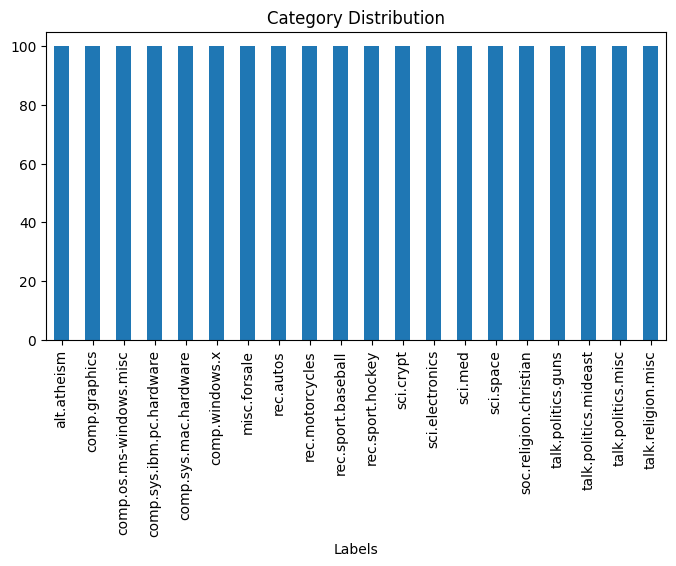

In [38]:
# To check class distribution
print("Category counts:\n", df["Labels"].value_counts())

# Plot distribution
df["Labels"].value_counts().plot(kind="bar", figsize=(8,4), title="Category Distribution")
plt.show()


In [39]:
# Text Preprocessing
# For preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [40]:
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
# Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
# Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
# Remove numbers
    text = re.sub(r'\d+', '', text)
# Tokenize
    tokens = nltk.word_tokenize(text)
# Remove stopwords and length filter
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
# Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Apply Cleaning
df["clean_text"] = df["Data"].apply(preprocess_text)
print(df[["Data", "clean_text"]].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                Data  \
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....   
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...   
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...   

                                          clean_text  
0  path cantaloupesrvcscmuedumagnesiumclubcccmued...  
1  newsgroups altatheism path cantaloupesrvcscmue...  
2  path cantaloupesrvcscmuedudasnewsharvardedunoc...  
3  path cantaloupesrvcscmuedumagnesiumclubcccmued...  
4  xref cantaloupesrvcscmuedu altatheism talkreli...  


- Preprocess text helps to turn messy text into consistent tokens model.
- Stopwords removal reduces noise.
- Lemmatization reduces morphological variants so the model sees fewer distinct tokens.

In [41]:
# Feature Extraction (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["clean_text"]).toarray()
y = df["Labels"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1600, 5000)
Shape of X_test: (400, 5000)
Shape of y_train: (1600,)
Shape of y_test: (400,)


In [42]:
''' # Encode labels
le = LabelEncoder()
df["label_enc"] = le.fit_transform(df["Labels"])

X = df["clean_text"]
y = df["label_enc"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

print("Train size:", len(X_train), "Test size:", len(X_test))'''


' # Encode labels\nle = LabelEncoder()\ndf["label_enc"] = le.fit_transform(df["Labels"])\n\nX = df["clean_text"]\ny = df["label_enc"]\n\n# Split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \n                                                    stratify=y, random_state=42)\n\nprint("Train size:", len(X_train), "Test size:", len(X_test))'

In [44]:
# Build pipeline
# The TfidfVectorizer is removed as the data is already vectorized
pipeline = Pipeline([
    ('clf', MultinomialNB())
])
# Train
pipeline.fit(X_train, y_train)
# Test
y_pred = pipeline.predict(X_test)

**TfidfVectorizer Uses:**
- ngram_range=(1,2): To include single words and parirs(bigrams).
- min_df = 2 : To ignore words that appear only once.
- max_df = 0.9 : To ignore overly common words.
- TF-IDF gives less weight to very common words and more to informative,rarer words.
- TF-IDF produces a large sparse matrix X where each column is a token and each row is a blog post.


Accuracy: 0.835


Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.50      0.78      0.61        18
           comp.graphics       0.80      0.89      0.84        18
 comp.os.ms-windows.misc       0.83      0.86      0.84        22
comp.sys.ibm.pc.hardware       0.83      0.76      0.79        25
   comp.sys.mac.hardware       0.86      0.86      0.86        21
          comp.windows.x       0.83      0.80      0.82        25
            misc.forsale       1.00      0.72      0.84        18
               rec.autos       0.94      0.94      0.94        18
         rec.motorcycles       0.83      0.94      0.88        16
      rec.sport.baseball       0.78      1.00      0.88        18
        rec.sport.hockey       0.94      1.00      0.97        15
               sci.crypt       0.86      1.00      0.93        19
         sci.electronics       0.67      0.75      0.71        16
                 sci.med       0.

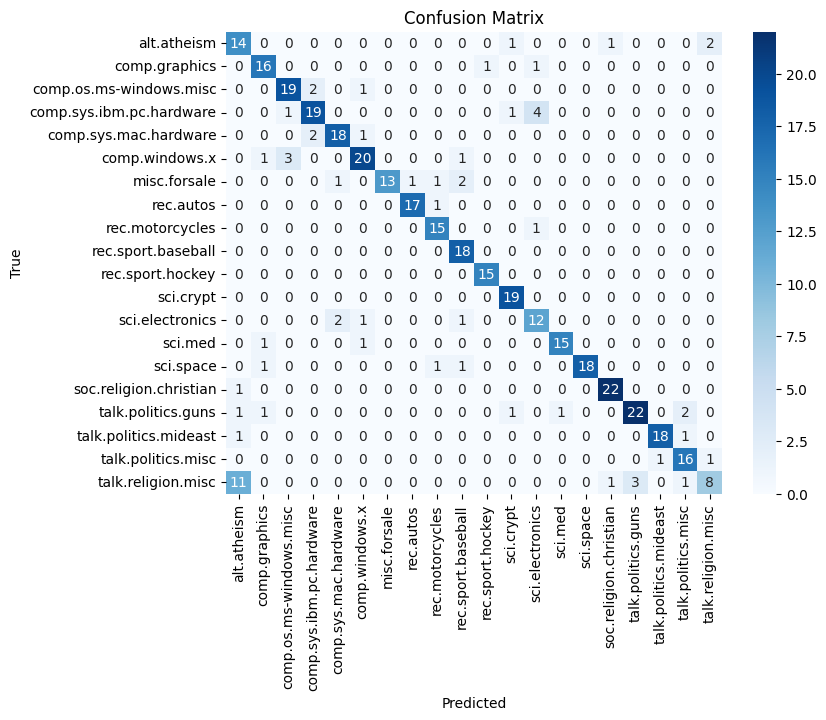

In [46]:
# Evaluate Model
# Accuracy

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\n")

# Detailed metrics
# Assuming 'le' is the LabelEncoder from the commented out cell 6iFh5ERnL6sj.
# If 'le' is not defined, you might need to uncomment and run cell 6iFh5ERnL6sj first.
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

print("\n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\n")
# Cross-validation is removed as the pipeline is no longer used for the entire dataset
# print("CV Accuracy:\n",Score.mean(), "+_",Score.std())

**Key Points**
- **Accuracy:** Fraction of correct predictions.
- **Confusion Matrix:** Useed to see which categories are confused with which.
- **CV Accuracy:** To check for a more robust estimate.

In [47]:
# Sentiment Analysis with VADER
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
  score = analyzer.polarity_scores(str(text))["compound"]
  if score >= 0.05 : return "Positive"
  elif score <= -0.05 : return "Negative"
  else : return "Neutral"

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                   Data sentiment
0     Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  Negative
1     Newsgroups: alt.atheism\nPath: cantaloupe.srv....  Positive
2     Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  Negative
3     Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  Negative
4     Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  Positive
...                                                 ...       ...
1995  Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...  Positive
1996  Xref: cantaloupe.srv.cs.cmu.edu talk.religion....  Positive
1997  Xref: cantaloupe.srv.cs.cmu.edu talk.origins:4...  Positive
1998  Xref: cantaloupe.srv.cs.cmu.edu talk.religion....  Positive
1999  Xref: cantaloupe.srv.cs.cmu.edu sci.skeptic:43...  Negative

[2000 rows x 2 columns]


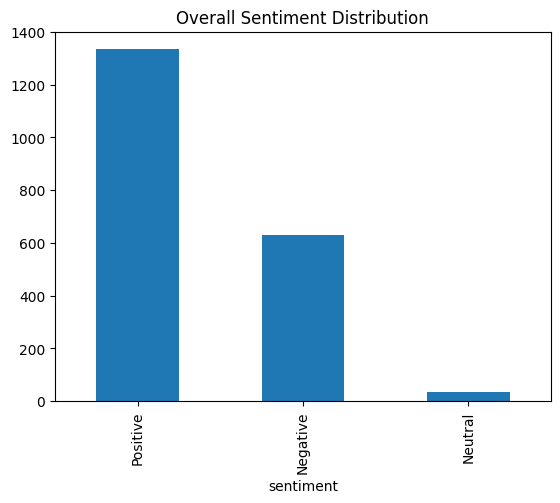

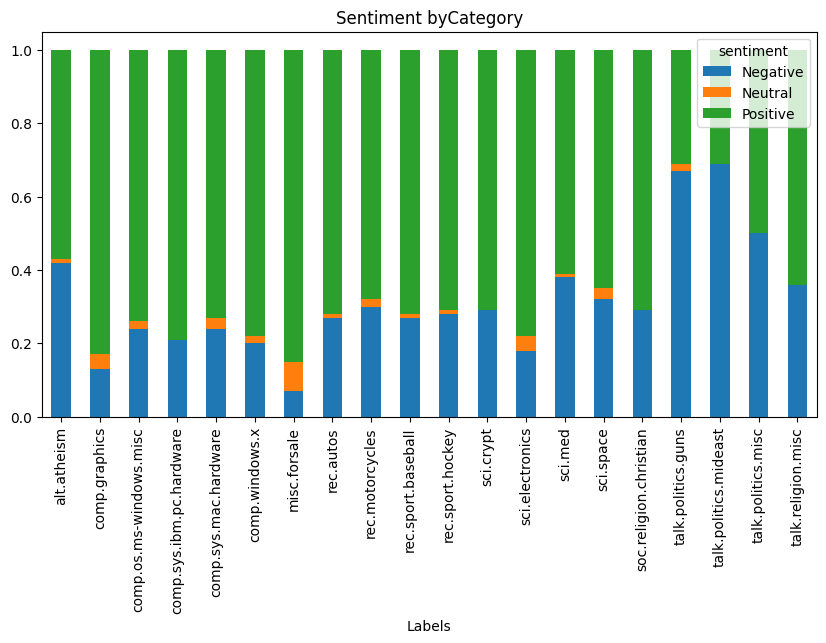

In [48]:
# Apply
df["sentiment"] = df["Data"].apply(get_sentiment)

print(df[["Data","sentiment"]])

# Overall distribution
df["sentiment"].value_counts().plot(kind="bar",title="Overall Sentiment Distribution")
plt.show()

# By category
sent_by_cat = pd.crosstab(df["Labels"],df["sentiment"],normalize="index")
sent_by_cat.plot(kind="bar",stacked=True,figsize=(10,5),title="Sentiment byCategory")
plt.show()

- **VADER Method Ueses:** It returns a *compound* score in [-1,1].
- compound >= 0.05 -> Positive.
- compound <= -0.05 -> Negative.
- otherwise -> Neutral.
- A new column **sentiment** with values (positive/negative/neutral).It insepct sentiment distribution and top postes.
- VADER is tuned for short posts.
